Goal:  Select features for a play-level model that calculates the potential of each play call (e.g. pass, rush, field goal, etc)  based on the situation and poer scores
    - X values are all the features we've gathered at the level of one record per game, where the target y = WIN/LOSS
    - Use stats and ML to select the fetures that impact wins and losses
    - we'll use these to create an offense-power and defense-power for each play in each  game
    - that should allow us to

Input: nfl_ml_weekly_stats.parquet

Activity:
    - Extract performance data
    - convert ints to float
    - measure correlation against the WIN/LOSS target
    - Classify important features from XGBoost
    - Classify weights from a shallow neural net
    - review that they are all in agreement and pick the best from each analysis
    - Use SHAP to get the relative weights (importance) for each feature
    - Manually separate stats that are offense-related and those that are defence related - for any given drive the offense and defense flip. and we want to be able to provide the stats for whichever team is on offense vs the stats for the opposing team
    - take the weighted average of each feature * its weights from SHAP - sum them all up to get a
    - this produces a **power_scores** dataset with single offense_power score and defense_power score for each team, for each season and week
    - query a version of the **play_actions** table from the database that we'll use to input for a play calling model
    - merge the **power_scores** and **play_actions** datasets, so we have the correct offense and defense 'powers' scored for each play, depending on which team is offense and defense.



# imports

In [1]:
import os
import pandas as pd
import sys

sys.path.append(os.path.abspath("../src"))

In [2]:
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import warnings

warnings.filterwarnings('ignore')


In [3]:
from src import *

# set flags

In [4]:
db = database_loader.DatabaseLoader(get_config('connection_string'))
DEBUG = False
SCHEMA = 'controls'

file_name = "nfl_ml_weekly_stats"
data_directory = get_config('data_directory')

input_path = os.path.join(data_directory,  f"{file_name}.parquet")
assert  os.path.exists(input_path)

plt.style.use('ggplot')


# load the NFL stats dataset

In [5]:
weekly_stats_df = pd.read_parquet(input_path)
stats_df = weekly_stats_df.drop(columns=['team'])
stats_df.head()

,season,week,spread,rush_attempts,rush_touchdowns,pass_touchdowns,interceptions,fumble,own_kickoff_recovery,safety,...,passing_air_yards,passing_yards_after_catch,avg_dakota,carries,rushing_yards,receptions,targets,receiving_yards,receiving_air_yards,receiving_yards_after_catch
index,,,,,,,,,,,,,,,,,,,,,
0,2022,1,-23,0,1,2,0,6,0,0,...,267.0,115.0,0.007858,22.0,103.0,24.0,36.0,205.0,266.0,115.0
1,2022,3,-8,3,0,0,0,2,0,0,...,356.0,166.0,-0.000555,21.0,70.0,37.0,55.0,314.0,332.0,166.0
2,2022,4,10,5,0,2,1,3,0,0,...,180.0,87.0,0.011065,37.0,132.0,23.0,31.0,207.0,182.0,87.0
3,2022,6,-10,5,0,0,1,4,0,0,...,333.0,114.0,0.003919,28.0,144.0,23.0,36.0,222.0,340.0,114.0
4,2022,7,8,2,1,1,0,2,0,0,...,216.0,94.0,0.013561,29.0,137.0,20.0,29.0,204.0,216.0,94.0


# perform feature selection

## prepare our data for feature selection
We'll have an X, and y set plus the original stats_df datasets, which we'll use going forward

In [6]:
stats_df['win'] = np.where(stats_df['spread'] > 0, 1, 0)
stats_df.drop(columns=['spread'], inplace=True)

In [7]:
dtype_mapping = {col: 'float' for col in stats_df.select_dtypes(include='int64')}
stats_df = stats_df.astype(dtype_mapping)

In [8]:
assert 0 == stats_df.isnull().sum().sum()


## define helper functions

In [9]:
from typing import Set, Any


def correlate_to_target(df: pd.DataFrame, target_column: str, top_n: int) -> (pd.DataFrame, Set):

    # Calculate correlation matrix
    correlation_matrix = df.corr()

    # Filter and sort correlation coefficients by absolute value
    corr_df = pd.DataFrame(correlation_matrix.abs().unstack().sort_values(ascending=False))
    corr_df.reset_index(inplace=True)
    corr_df.columns = ['x', 'y', 'corr']

    not_self_correlated = (corr_df.y != target_column)
    win_correlated = (corr_df.x == target_column)

    df = corr_df.loc[ win_correlated & not_self_correlated ]\
        .sort_values(by='corr', ascending=False)\
        .drop(columns=['x'])\
        .head(top_n)\
        .copy()

    s = set(df['y'].values)

    return df, s


def calc_feature_importance(X: pd.DataFrame, y: pd.Series, top_n=30) -> (pd.DataFrame, Set):
    # Create an XGBoost model
    model = xgb.XGBRegressor()

    # Fit the model
    model.fit(X, y)

    # Get feature importance scores
    importance_scores = model.feature_importances_

    # Sort feature importance scores
    sorted_indices = importance_scores.argsort()[::-1]
    sorted_scores = importance_scores[sorted_indices]
    feature_names = X.columns[sorted_indices]

    # Get the top 'n' feature importance scores and names
    top_scores = sorted_scores[:top_n]
    top_features = feature_names[:top_n]
    df = pd.DataFrame({'y': top_features, 'corr': top_scores})

    set_xg_cols = set(top_features)
    return df, set(top_features)


def plot_correlations(scores: Any, features: Any, title: str):

    # Plot feature importance
    plt.figure(figsize=(10, 10))
    plt.barh(range(len(scores)), scores, align='center')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Score')
    plt.ylabel('Column')
    plt.title(title)
    plt.show()




## get cross correlations

In [10]:
top_correlations, set_correlations = correlate_to_target(stats_df, 'win', 30)

## create xy dataset slices

In [11]:
import numpy as np


X = stats_df.drop(columns=['win']).copy()
y = stats_df['win']

print(X.shape)
print(y.shape)
y.value_counts()

(3569, 61)
(3569,)


1.0    2064
0.0    1505
Name: win, dtype: int64

## determine feature importance

In [12]:
top_features, set_features = calc_feature_importance(X, y, top_n=30)


## review correlations, importance and choose the best features

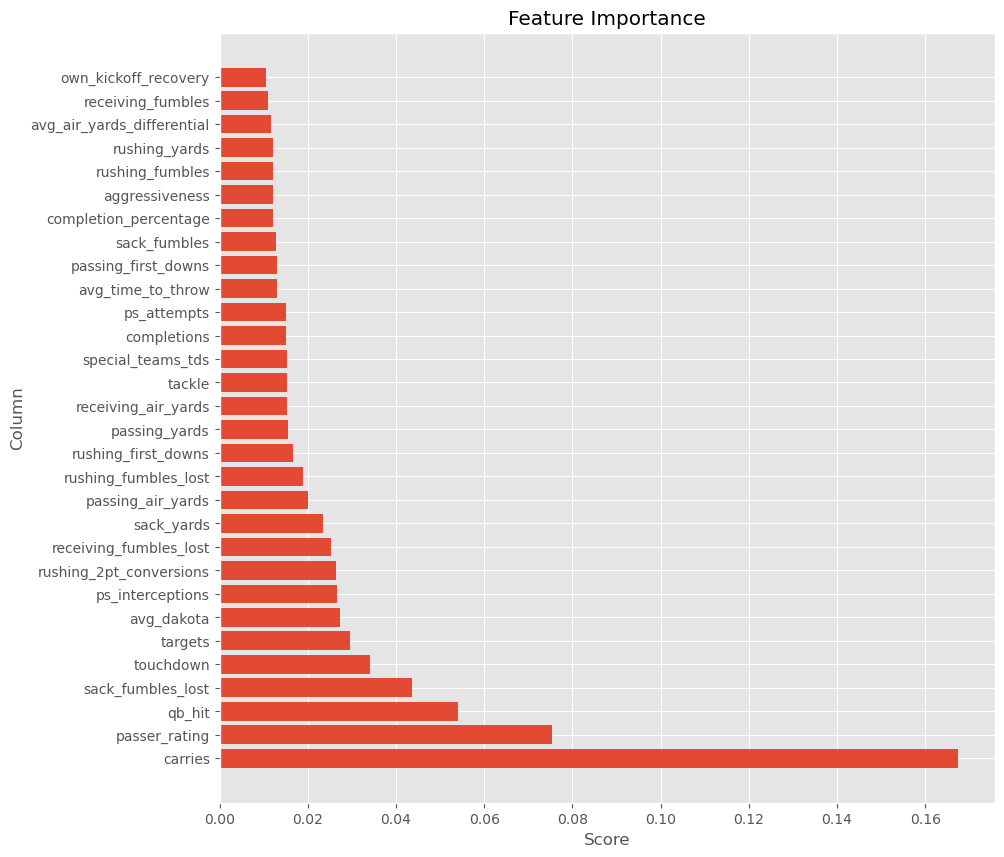

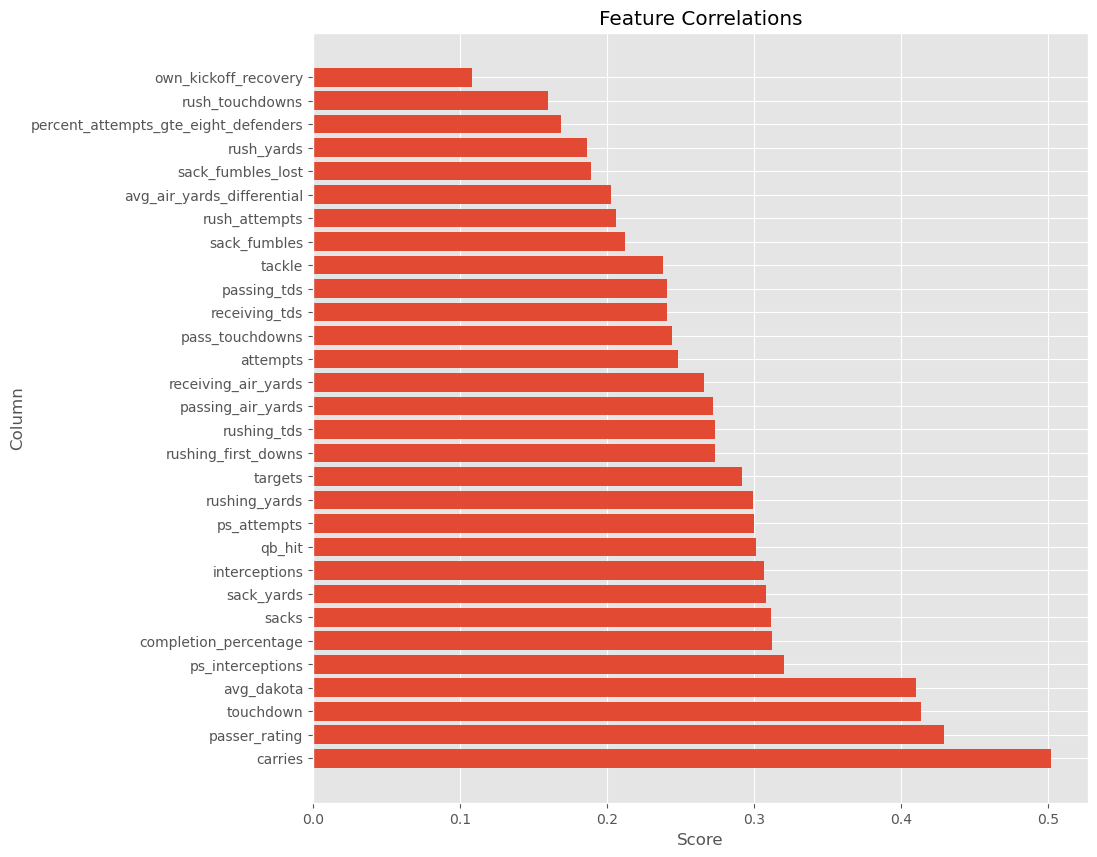

In [13]:
plot_correlations(top_features['corr'], top_features['y'], "Feature Importance")
plot_correlations(top_correlations['corr'], top_correlations['y'], 'Feature Correlations')

In [14]:
target_columns = list(set_features.union(set_correlations))
X_pandas = X[target_columns]

# validate feature set against nn model

## scale and normalize data

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Create the scaler object
scaler = MinMaxScaler()

# Normalize selected columns in a DataFrame
X = scaler.fit_transform(X_pandas)



## train test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


## create and fit nn model

In [17]:
from keras.src.callbacks import EarlyStopping
from keras.src.optimizers import Adam
from keras import regularizers

# Set parameters
learning_rate = .001
activation_function = "relu"
output_function = "sigmoid"
loss_function = 'binary_crossentropy'
regularization_function = regularizers.l1(0.01)
optimizer=Adam(learning_rate=learning_rate)


# Create a neural network model
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation=activation_function, kernel_regularizer=regularization_function))
model.add(Dense(32, activation=activation_function, kernel_regularizer=regularization_function))
model.add(Dense(1, activation=output_function))  # Single output neuron for binary classification

model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
r = model.fit(X_train, y_train, epochs=200, batch_size=64, verbose=0, validation_data=(X_test, y_test), callbacks=[early_stopping])


2023-07-13 19:59:22.216395: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-13 19:59:22.216416: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-13 19:59:22.216420: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-13 19:59:22.216453: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-13 19:59:22.216467: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-13 19:59:22.592775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-13 19:59:23.210982:

# evaluate model performance

#### plot loss

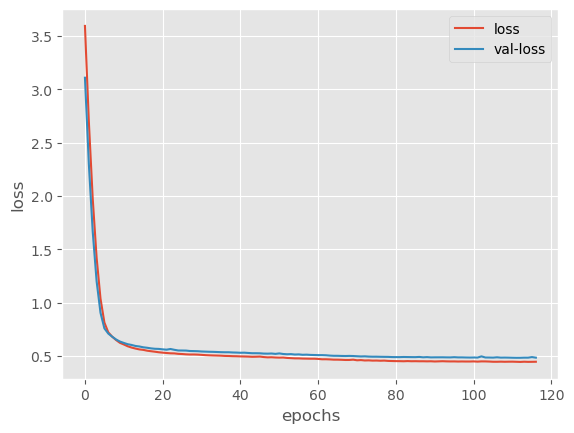

In [18]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val-loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#### plot accuracy

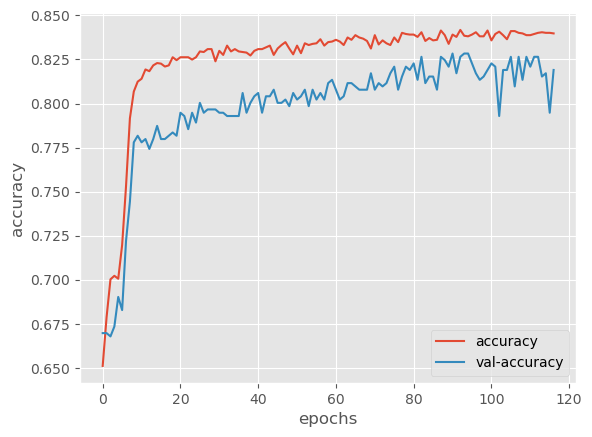

In [19]:
# Evaluate the model
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val-accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

#### confusion matrix

17/17 [==============================] - 0s 2ms/step


2023-07-13 19:59:58.295104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


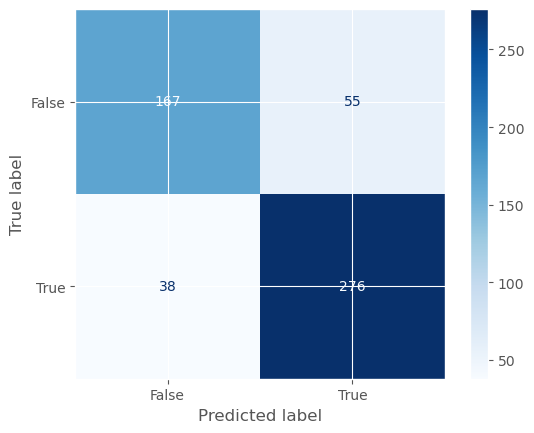

In [20]:
# Make predictions with the model
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot(cmap='Blues')
plt.show()

#### classification scores

In [21]:

# Make predictions with the model
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Calculate precision, recall, and F1 scores
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("")
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

17/17 [==============================] - 0s 1ms/step

Precision: 0.8338368580060423
Recall: 0.8789808917197452
F1-score: 0.8558139534883721


#### roc curve

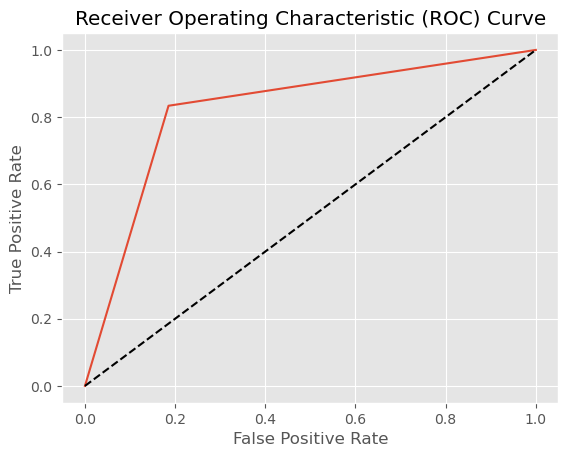

In [22]:
from src.util_keras import plot_roc_curve

plot_roc_curve(y_pred, y_test)

#### auc score

In [23]:
from sklearn.metrics import roc_auc_score

# Assuming you have y_actual and y_predicted for binary classification
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)


AUC: 0.8156165719859987


#### model weights

2023-07-13 19:59:58.821831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


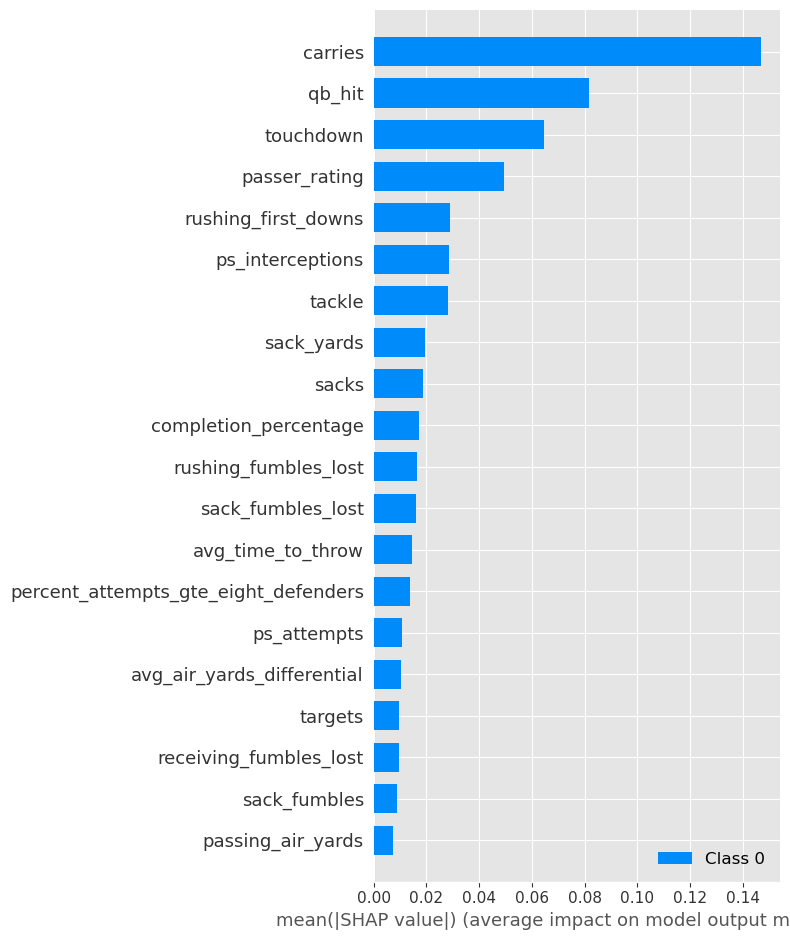

In [24]:
import shap

# Assuming you have a trained Keras model 'model' and a dataset 'X'
explainer = shap.DeepExplainer(model, data=X_train)
shap_values = explainer.shap_values(X_train)

# Convert X_train to a pandas DataFrame with column names
X_train_columns = X_pandas.columns
X_train_df = pd.DataFrame(X_train, columns=X_train_columns)

# Calculate the summary data
# Convert SHAP values to a DataFrame with column names
shap_values_2d = np.squeeze(shap_values)
shap_values_df = pd.DataFrame(shap_values_2d, columns=X_train_columns)

# Calculate the mean absolute SHAP values and standard deviations
summary_data = pd.DataFrame({
    'Feature': X_train_columns,
    'Mean': np.abs(shap_values_df).mean(axis=0)
})

# Plotting the SHAP values with column names
shap.summary_plot(shap_values, X_train_df, feature_names=X_train_columns)


manual step - decide which features are offense or defense

helper functions to take the SHAP scores and apply weighted averages back into to the original data


the weighted averages of offense and defense features becomes the offense and defense 'power' score
These values are not necessarily proportional, so you can't simply subtract the offense power from the defense power
and you might just leave these values instead of calculating a single score, but it will be quicker to train, and easier t understand
and we can still gauge the effectiveness of the single score and change back if required

In [25]:
from src.build_power_scores import build_power_datasets

offense_features = ['carries', 'touchdown', 'rushing_first_downs', 'passer_rating']
defense_features = ['qb_hit', 'ps_interceptions', 'tackle', 'sacks']

offense_power_df, defense_power_df = build_power_datasets(weekly_stats_df, summary_data, offense_features, defense_features)

#### save feature selection model

In [26]:
%%time
pbp_actions_df = db.query_to_df("""
WITH play_actions AS (
    -- select play by play data from the play_action table
    -- this will be our base table for building a play call dataset
    -- get rid of clock events, penalties and other features that are not pass, rush, field goal
    -- for example, for this dataset a PUNT is just a turnover - it's an important play call
    --     but it's really just a way of turning the ball over - if we don't punt, the action keeps going
    --     so the fact that we punted or did not punt on forth down is already captured in the fact that we are running a play on 4th down
    --     in this dataset we are interested in actions and their resulting rewards
    -- todo - we do need to get 2pt conversion into this set
    select season, week, game_id, play_id,
           drive,
           play_counter,
           posteam,
           posteam_score::integer,
           posteam_score_post::integer,
           defteam,
           defteam_score,
           defteam_score_post,
           (posteam_score - defteam_score) as point_differential,
           down,
           yrdln,
           SUBSTRING(yrdln FROM '[0-9]+')::integer as yard_line,   -- we'll split yrdln column e.g. 'BAL 25' --> 25
           SUBSTRING(yrdln FROM '[A-Za-z]+') AS side_of_field,  -- we'll split yrdln column e.g. 'BAL 25' --> BAL
           ydstogo,
           game_seconds_remaining,
           action,
           yards_gained,
           row_number() over (partition by     -- make sure we are not creating unwanted records
               season,
               week,
               play_counter) as rn
    from controls.play_actions
    where action in (
                     'extra_point',
                     'field_goal',
                     'pass',
                     'rush')
),
next_starting_scores AS (
    -- intermediate step:
    -- get the score from the next down into the current record
    -- assign a unique row_id so we can validate it only occurs once in the final dataset
      SELECT
          *,
          ROW_NUMBER() OVER (ORDER BY (SELECT NULL)) AS row_id,
          LEAD(posteam_score) OVER (PARTITION BY season, week, posteam, drive ORDER BY  play_counter) AS next_starting_score
     FROM play_actions
     WHERE rn = 1
     ORDER BY season, week, game_id, play_counter
 )

-- almost final step :
-- join everything to this point together
-- but don't join in offense and defense powers here because we want to be abe to validate during development that this much does not fan out
-- calc yards_to_goal e.g. if we are on our own side of the field then yards-to-goal is 100 minus the yard line
-- finally, since we LEAD() the score from the next play up to the current play so we can see what the difference was - that is the points_gained on this play
SELECT
    ns.row_id,
    pa.season,
    pa.week,
    pa.game_id,
    pa.drive,
    pa.play_counter,
    pa.posteam,
    pa.posteam_score,
    pa.posteam_score_post,
    pa.defteam,
    pa.defteam_score,
    pa.defteam_score_post,
    pa.point_differential,
    ns.next_starting_score,
    pa.down,
    pa.ydstogo,
    CASE WHEN pa.posteam = pa.side_of_field THEN 100 - pa.yard_line ELSE pa.yard_line END AS yards_to_goal,
    pa.game_seconds_remaining,
    pa.action,
    pa.yards_gained,
    CASE WHEN ns.next_starting_score is not null THEN ns.next_starting_score - pa.posteam_score ELSE pa.posteam_score_post - pa.posteam_score END AS points_gained
FROM play_actions AS pa
         JOIN next_starting_scores AS ns ON pa.play_id = ns.play_id
WHERE pa.rn = 1 """)

pbp_actions_df.head()

CPU times: user 1.22 s, sys: 141 ms, total: 1.36 s
Wall time: 2.82 s


,row_id,season,week,game_id,drive,play_counter,posteam,posteam_score,posteam_score_post,defteam,...,defteam_score_post,point_differential,next_starting_score,down,ydstogo,yards_to_goal,game_seconds_remaining,action,yards_gained,points_gained
0,3,2016,1,2016_01_DET_IND,1.0,55.0,IND,0,0,DET,...,0.0,0.0,0.0,1.0,10.0,75,3600.0,pass,6.0,0
1,4,2016,1,2016_01_MIN_TEN,1.0,58.0,TEN,0,0,MIN,...,0.0,0.0,0.0,1.0,10.0,71,3594.0,rush,6.0,0
2,6,2016,1,2016_01_NYG_DAL,1.0,60.0,DAL,0,0,NYG,...,0.0,0.0,0.0,1.0,10.0,75,3600.0,rush,1.0,0
3,7,2016,1,2016_01_GB_JAX,1.0,62.0,JAX,0,0,GB,...,0.0,0.0,0.0,1.0,10.0,82,3596.0,rush,6.0,0
4,10,2016,1,2016_01_MIA_SEA,1.0,75.0,SEA,0,0,MIA,...,0.0,0.0,0.0,2.0,3.0,68,3569.0,pass,6.0,0


In [27]:
%%time
full_path = os.path.join(data_directory, "pbp_actions.parquet")
pbp_actions_df.to_parquet(full_path)

CPU times: user 114 ms, sys: 14.8 ms, total: 129 ms
Wall time: 124 ms


In [28]:
offense_power_df.head()

,team,season,week,offense_power
0,ARI,2016,1,28.751645
1,ARI,2016,2,38.010825
2,ARI,2016,3,18.231250
3,ARI,2016,4,28.217851
4,ARI,2016,5,33.784695


In [29]:
defense_power_df.head()

,team,season,week,defense_power
0,ARI,2016,1,16.028442
1,ARI,2016,2,17.571463
2,ARI,2016,3,19.256932
3,ARI,2016,4,12.996981
4,ARI,2016,5,21.221539


In [30]:
%%time
full_path = os.path.join(data_directory, "offense_power.parquet")
offense_power_df.to_parquet(full_path)

CPU times: user 2.18 ms, sys: 1.4 ms, total: 3.59 ms
Wall time: 2.74 ms


In [31]:
%%time
full_path = os.path.join(data_directory, "defense_power.parquet")
defense_power_df.to_parquet(full_path)

CPU times: user 2.22 ms, sys: 1.57 ms, total: 3.79 ms
Wall time: 2.96 ms
